In [1]:
import numpy,sys,matplotlib,logging
import scanpy,velocyto

%matplotlib inline
matplotlib.rcParams['pdf.fonttype'] = 42

# 1. Visualization

In [2]:
idata=scanpy.read_csv('/Volumes/omics4tb2/alomana/projects/mscni/data/scanpy/count.file.all.day.clean.csv')

In [3]:
adata=idata.transpose()

scanpy.pp.filter_cells(adata,min_genes=200)
scanpy.pp.filter_genes(adata,min_cells=3)

adata.obs['n_counts'] = adata.X.sum(axis=1)

scanpy.pp.normalize_per_cell(adata, counts_per_cell_after=1e5)
scanpy.pp.log1p(adata)

adata.raw = adata

scanpy.pp.highly_variable_genes(adata,min_mean=0.0125,max_mean=6,min_disp=0.25) # 2,851
adata = adata[:, adata.var['highly_variable']]

scanpy.pp.regress_out(adata,['n_counts'])
scanpy.pp.scale(adata, max_value=10)

# placeholder to regress out cell cycle

In [4]:
cellIDs=adata.obs_names.tolist()

dayLabels=[]; uDayLabels=[]
for cellID in cellIDs:
    broken=cellID.split('_M397.')
    dayLabel=broken[1]
    dayLabels.append(dayLabel)
    if dayLabel not in uDayLabels:
        uDayLabels.append(dayLabel) 
print(uDayLabels)
dayLabelIntegers=[uDayLabels.index(element) for element in dayLabels]
adata.obs['dayLabel']=dayLabels
adata.obs['dayLabelInteger']=dayLabelIntegers

['control', 'day3', 'day6', 'day13', 'day17', 'day24']


... storing 'dayLabel' as categorical


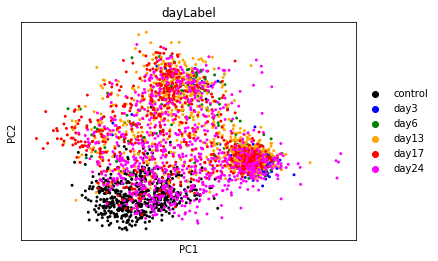

In [5]:
scanpy.tl.pca(adata,svd_solver='arpack')
scanpy.pl.pca(adata,color=['dayLabel'],palette=['black','blue','green','orange','red','magenta'])

/Users/alomana/anaconda3/lib/python3.7/site-packages/umap/umap_.py:349: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../../anaconda3/lib/python3.7/site-packages/umap/umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^

  @numba.jit()
/Users/alomana/anaconda3/lib/python3.7/site-packages/numba/compiler.py:725: NumbaWarning: Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "../../../anaconda3/lib/python3.7/site-packages/umap/umap_.py", line 350:
@numba.jit()
def fuzzy_simplicial_set(
^

  self.func_ir.loc))
/Users/alomana/anaconda3/lib/python3.7/site-packages/numba/compiler.py:734: NumbaDeprecationWarning: 
Fall-back 

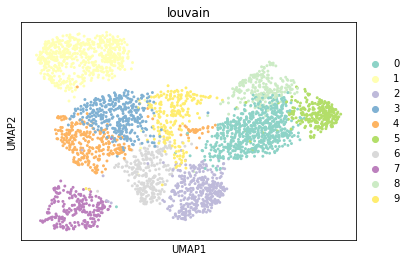

In [6]:
scanpy.pp.neighbors(adata,n_neighbors=12,n_pcs=50)
scanpy.tl.umap(adata)
scanpy.tl.louvain(adata)
scanpy.pl.umap(adata,color=['louvain'],palette='Set3')

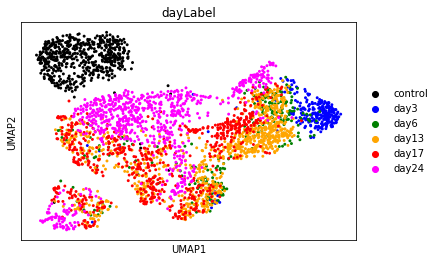

In [7]:
scanpy.pl.umap(adata,color=['dayLabel'],palette=['black','blue','green','orange','red','magenta'])

In [8]:
cell_cluster_map=adata.obs['louvain'].to_dict()
cells_barcodes_per_day={}
barcodes=[]
for element in list(cell_cluster_map.keys()):
    day_label=element.split('.')[1]
    barcode=element.split('_M397')[0]
    barcodes.append(barcode)
    if day_label not in cells_barcodes_per_day:
        cells_barcodes_per_day[day_label]=[barcode]
    else:
        cells_barcodes_per_day[day_label].append(barcode)

print(adata)
print(len(barcodes))
unique_barcodes=list(set(barcodes))
print(len(unique_barcodes))
print(cells_barcodes_per_day.keys())
print(cells_barcodes_per_day['control'][:10])

AnnData object with n_obs × n_vars = 3477 × 2851 
    obs: 'n_genes', 'n_counts', 'dayLabel', 'dayLabelInteger', 'louvain'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'dayLabel_colors', 'neighbors', 'louvain', 'louvain_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
3477
3471
dict_keys(['control', 'day3', 'day6', 'day13', 'day17', 'day24'])
['AAACCTGCAAGAGGCT', 'AAACGGGTCATTCACT', 'AAAGATGAGTCCAGGA', 'AAAGATGCACTTACGA', 'AAAGATGGTGCCTGGT', 'AACCGCGTCTCAAACG', 'AACGTTGAGGGATACC', 'AACGTTGTCTCGTTTA', 'AACTCAGTCACATACG', 'AACTCCCTCTCGCATC']


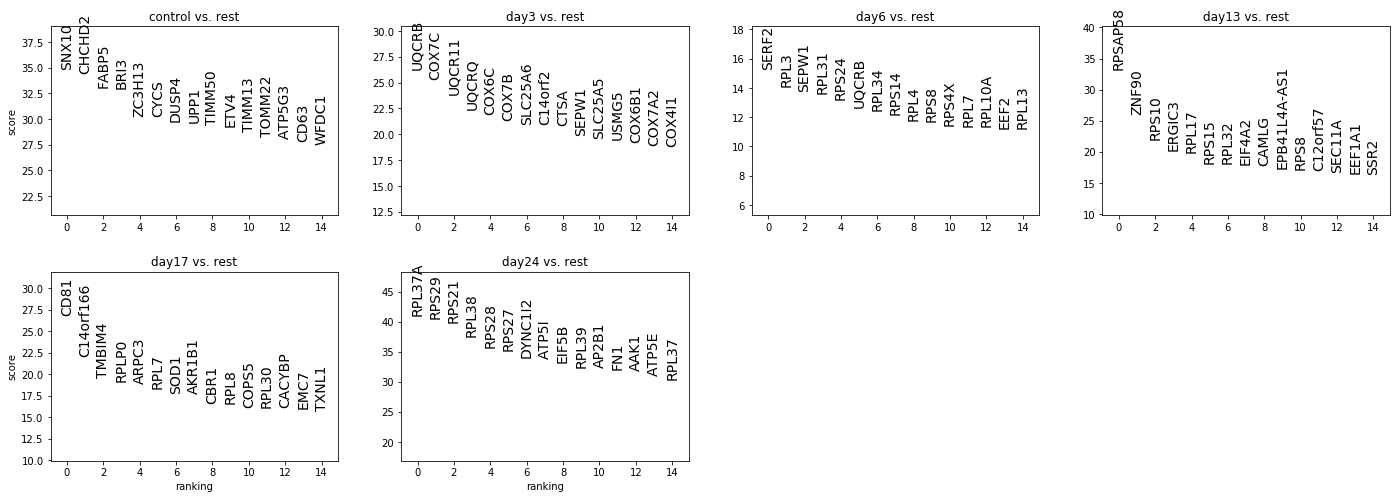

In [9]:
scanpy.tl.rank_genes_groups(adata, 'dayLabel', method='wilcoxon')
scanpy.pl.rank_genes_groups(adata, n_genes=15, sharey=False,fontsize=14)

In [10]:
marker_genes=['SNX10','UQCRB','SERF2','RPSAP58']

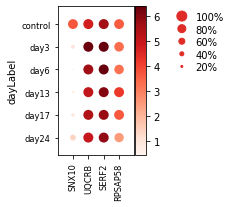

In [11]:
ax = scanpy.pl.dotplot(adata, marker_genes, groupby='dayLabel')

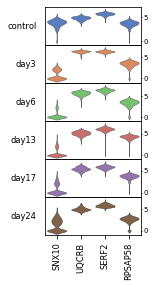

In [12]:
ax = scanpy.pl.stacked_violin(adata, marker_genes, groupby='dayLabel', rotation=90)

# 2. Velocity analysis

In [13]:
logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=logging.DEBUG)

In [14]:
vlm=velocyto.VelocytoLoom("/Volumes/omics4tb2/alomana/projects/mscni/results/velocyto/combined.loom")

In [15]:
vlm.normalize("S",size=True,log=True)
vlm.normalize("U",size=True,log=True)

In [16]:
vlm.filter_cells(bool_array=vlm.initial_Ucell_size > numpy.percentile(vlm.initial_Ucell_size, 0.4))

In [17]:
sample_rosetta={}
sample_rosetta['20765_M397_control']='control'
sample_rosetta['21729_day3']='day3'
sample_rosetta['21766_day6']='day6'
sample_rosetta['22077_day13']='day13'
sample_rosetta['22152_day17']='day17'
sample_rosetta['18324_Yapeng_single_cell']='day24'

selected_cells=[]
all_cells=vlm.ca['CellID']

for cellID in all_cells:
    day_label=sample_rosetta[cellID.split(':')[0]]
    barcode=cellID.split(':')[1].replace('x','')
    
    if barcode in cells_barcodes_per_day[day_label]:
        selected_cells.append(cellID)
        
mask=numpy.isin(vlm.ca['CellID'],selected_cells)
print(mask,mask.shape)
    
print(vlm.ca['CellID'].shape[0])
print(vlm.ca['CellID'])
vlm.filter_cells(bool_array=mask)
print(vlm.ca['CellID'].shape[0])

[False  True False ... False False  True] (7366,)
7366
['20765_M397_control:AAGACCTCAGGTCCACx'
 '20765_M397_control:AACTCAGTCACATACGx'
 '20765_M397_control:AAATGCCAGGCTCTTAx' ...
 '18324_Yapeng_single_cell:TTTGTCAAGTATCGAAx'
 '18324_Yapeng_single_cell:TTGGAACCATCGATGTx'
 '18324_Yapeng_single_cell:TTTACTGCAATCAGAAx']
3477


In [18]:
# communicate cell clusters to velocyto
vlm.set_clusters(adata.obs['louvain'].values)

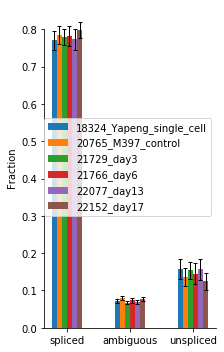

In [19]:
vlm.plot_fractions()

In [20]:
vlm.score_detection_levels(min_expr_counts=40, min_cells_express=30)
vlm.filter_genes(by_detection_levels=True)

2019-08-13 17:10:24,755 - DEBUG - Filtering by detection level


2019-08-13 17:10:25,835 - DEBUG - svr_gamma set to 0.012173348482389223
2019-08-13 17:10:28,097 - DEBUG - Filtering by cv vs mean


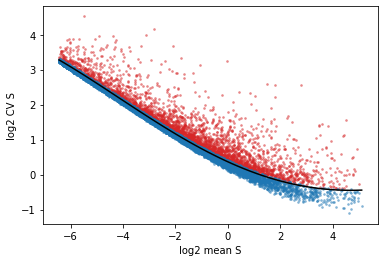

In [21]:
vlm.score_cv_vs_mean(3000, plot=True, max_expr_avg=35)
vlm.filter_genes(by_cv_vs_mean=True)

In [22]:
vlm.score_detection_levels(min_expr_counts=0, min_cells_express=0,min_expr_counts_U=25, min_cells_express_U=20)
vlm.score_cluster_expression(min_avg_U=0.01, min_avg_S=0.08)
vlm.filter_genes(by_detection_levels=True, by_cluster_expression=True)

2019-08-13 17:10:28,325 - INFO - Cluster: b'0' (657 cells)
2019-08-13 17:10:28,347 - INFO - Cluster: b'1' (569 cells)
2019-08-13 17:10:28,365 - INFO - Cluster: b'2' (378 cells)
2019-08-13 17:10:28,378 - INFO - Cluster: b'3' (344 cells)
2019-08-13 17:10:28,390 - INFO - Cluster: b'4' (317 cells)
2019-08-13 17:10:28,402 - INFO - Cluster: b'5' (273 cells)
2019-08-13 17:10:28,411 - INFO - Cluster: b'6' (262 cells)
2019-08-13 17:10:28,420 - INFO - Cluster: b'7' (230 cells)
2019-08-13 17:10:28,429 - INFO - Cluster: b'8' (230 cells)
2019-08-13 17:10:28,438 - INFO - Cluster: b'9' (217 cells)
2019-08-13 17:10:28,446 - DEBUG - Filtering by cluster expression
2019-08-13 17:10:28,447 - DEBUG - Filtering by detection level


In [23]:
vlm._normalize_S(relative_size=vlm.S.sum(0),
             target_size=vlm.S.sum(0).mean())
vlm._normalize_U(relative_size=vlm.U.sum(0),
             target_size=vlm.U.sum(0).mean())

28

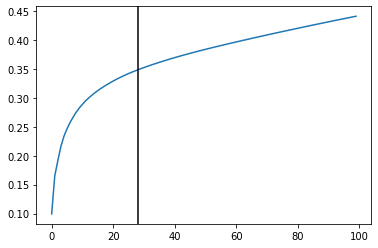

In [24]:
vlm.perform_PCA()
matplotlib.pyplot.plot(numpy.cumsum(vlm.pca.explained_variance_ratio_)[:100])
n_comps = numpy.where(numpy.diff(numpy.diff(numpy.cumsum(vlm.pca.explained_variance_ratio_))>0.002))[0][0]
matplotlib.pyplot.axvline(n_comps, c="k")
n_comps

In [25]:
number_of_cells=vlm.ca['CellID'].shape[0]
nei=int(0.025*number_of_cells)*3
nei=250
print(number_of_cells,nei)

3477 250


In [26]:
vlm.knn_imputation(k=nei,n_pca_dims=n_comps,balanced=True,n_jobs=8,b_sight=nei*8, b_maxl=nei*4,group_constraint=numpy.array(adata.obs['dayLabelInteger']))

2019-08-13 17:10:33,015 - DEBUG - First search the 2000 nearest neighbours for 3477
2019-08-13 17:10:33,977 - DEBUG - Using the initialization network to find a 250-NN graph with maximum connectivity of 1000
2019-08-13 17:10:34,030 - DEBUG - Returning sparse matrix


In [27]:
vlm.fit_gammas()

In [28]:
vlm.filter_genes_by_phase_portrait()

In [29]:
vlm.predict_U()
vlm.calculate_velocity()
vlm.calculate_shift(assumption="constant_velocity")
vlm.extrapolate_cell_at_t(delta_t=1.)

In [30]:
positions=adata.obsm['X_umap']
vlm.ts=positions

In [31]:
vlm.estimate_transition_prob(hidim="Sx_sz", embed="ts", transform="sqrt", psc=1,n_neighbors=nei, knn_random=True, sampled_fraction=0.5)
vlm.calculate_embedding_shift(sigma_corr = 0.05, expression_scaling=True)

2019-08-13 17:10:47,714 - DEBUG - Calculate KNN in the embedding space


/Users/alomana/anaconda3/lib/python3.7/site-packages/velocyto/analysis.py:1569: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  p=p) for i in range(neigh_ixs.shape[0])), 0)


2019-08-13 17:10:48,310 - DEBUG - Correlation Calculation 'knn_random'
2019-08-13 17:10:51,386 - DEBUG - Correlation Calculation for negative control
2019-08-13 17:10:54,367 - DEBUG - Done Correlation Calculation
2019-08-13 17:10:54,378 - DEBUG - Calculate transition probability
2019-08-13 17:10:54,498 - DEBUG - Calculate transition probability for negative control


In [32]:
louvain_colors=[adata.uns['louvain_colors'][int(element)] for element in adata.obs['louvain']]

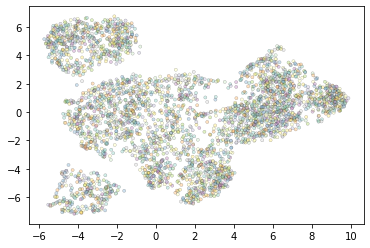

In [33]:
# overlay arrows
ix_choice = numpy.random.choice(vlm.embedding.shape[0], size=int(vlm.embedding.shape[0]/1.), replace=False)
matplotlib.pyplot.scatter(vlm.embedding[ix_choice, 0], vlm.embedding[ix_choice, 1],c=louvain_colors, alpha=0.4, s=10, edgecolor=(0,0,0,1), lw=0.3, rasterized=True)

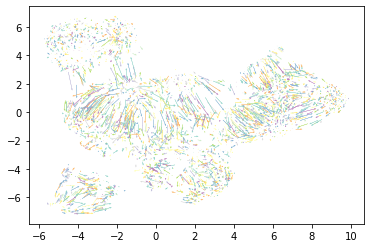

In [34]:
quiver_kwargs=dict(headaxislength=7, headlength=11, headwidth=8,linewidths=0.25, width=0.00045,edgecolors=louvain_colors, color=louvain_colors, alpha=1)
matplotlib.pyplot.quiver(vlm.embedding[ix_choice, 0], vlm.embedding[ix_choice, 1],vlm.delta_embedding[ix_choice, 0], vlm.delta_embedding[ix_choice, 1],**quiver_kwargs)

250


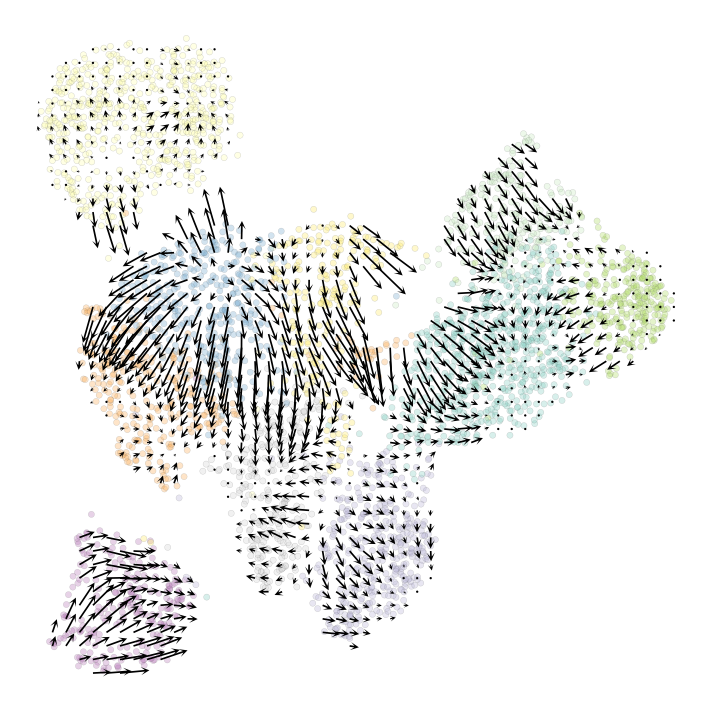

In [35]:
vlm.calculate_grid_arrows(smooth=0.95, steps=(50,50),n_neighbors=50)
print(nei)

matplotlib.pyplot.figure(None,(10,10))
vlm.colorandum=louvain_colors
vlm.plot_grid_arrows(quiver_scale='auto',scatter_kwargs_dict={"alpha":0.35, "lw":0.35, "edgecolor":"0.4", "s":38, "rasterized":True}, min_mass=10, angles='xy', scale_units='xy',headaxislength=2.75, headlength=5, headwidth=4.8, minlength=1.5,plot_random=False)
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.savefig("figures/figure.velo.16.pdf")

In [36]:
# placeholder for velocity of markers


In [37]:
# placeholder for day by day